# README

### To run this notebook correctly without errors, create a new environment using my _requirements.txt_ file. 
The structure in my working folder was as follows:
1. train - folder with training files
2. nfl_kaggle.ipynb

The cache and results folders will be created during the process.


In [2]:
import os
import re
import glob
import json
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.neighbors import KDTree
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# EDA

## Structure Analysis

In [5]:
files_input = sorted(glob.glob("train/input_2023_w*.csv"))
files_output = sorted(glob.glob("train/output_2023_w*.csv"))

INPUT_DFS = []
OUTPUT_DFS = []

for f_in, f_out in zip(files_input, files_output):
    df_in = pd.read_csv(f_in)
    df_out = pd.read_csv(f_out)

    week_match = re.search(r"w(\d+)", f_out)
    week = int(week_match.group(1)) if week_match else None

    df_in["week"] = week
    df_out["week"] = week

    INPUT_DFS.append(df_in)
    OUTPUT_DFS.append(df_out)

    print(f"{f_in}: {df_in.shape}, {f_out}: {df_out.shape}, week: {week}")

train\input_2023_w01.csv: (285714, 24), train\output_2023_w01.csv: (32088, 7), week: 1
train\input_2023_w02.csv: (288586, 24), train\output_2023_w02.csv: (32180, 7), week: 2
train\input_2023_w03.csv: (297757, 24), train\output_2023_w03.csv: (36080, 7), week: 3
train\input_2023_w04.csv: (272475, 24), train\output_2023_w04.csv: (30147, 7), week: 4
train\input_2023_w05.csv: (254779, 24), train\output_2023_w05.csv: (29319, 7), week: 5
train\input_2023_w06.csv: (270676, 24), train\output_2023_w06.csv: (31162, 7), week: 6
train\input_2023_w07.csv: (233597, 24), train\output_2023_w07.csv: (27443, 7), week: 7
train\input_2023_w08.csv: (281011, 24), train\output_2023_w08.csv: (33017, 7), week: 8
train\input_2023_w09.csv: (252796, 24), train\output_2023_w09.csv: (28291, 7), week: 9
train\input_2023_w10.csv: (260372, 24), train\output_2023_w10.csv: (29008, 7), week: 10
train\input_2023_w11.csv: (243413, 24), train\output_2023_w11.csv: (27623, 7), week: 11
train\input_2023_w12.csv: (294940, 24), t

In [6]:
input_1 = INPUT_DFS[0]
output_1 = OUTPUT_DFS[0]

print(input_1.shape, output_1.shape)

(285714, 24) (32088, 7)


In [7]:
input_1.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,week
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,52.33000,36.94000,0.09000,0.39000,322.40000,238.24000,21,63.26000,-0.22000,1
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,52.33000,36.94000,0.04000,0.61000,200.89000,236.05000,21,63.26000,-0.22000,1
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,52.33000,36.93000,0.12000,0.73000,147.55000,240.60000,21,63.26000,-0.22000,1
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,52.35000,36.92000,0.23000,0.81000,131.40000,244.25000,21,63.26000,-0.22000,1
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,52.37000,36.90000,0.35000,0.82000,123.26000,244.25000,21,63.26000,-0.22000,1


In [8]:
output_1.head()

,game_id,play_id,nfl_id,frame_id,x,y,week
0,2023090700,101,46137,1,56.22000,17.28000,1
1,2023090700,101,46137,2,56.63000,16.88000,1
2,2023090700,101,46137,3,57.06000,16.46000,1
3,2023090700,101,46137,4,57.48000,16.02000,1
4,2023090700,101,46137,5,57.91000,15.56000,1


In [9]:
input_1.info()

input_1['player_to_predict'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285714 entries, 0 to 285713
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   game_id                   285714 non-null  int64  
 1   play_id                   285714 non-null  int64  
 2   player_to_predict         285714 non-null  bool   
 3   nfl_id                    285714 non-null  int64  
 4   frame_id                  285714 non-null  int64  
 5   play_direction            285714 non-null  object 
 6   absolute_yardline_number  285714 non-null  int64  
 7   player_name               285714 non-null  object 
 8   player_height             285714 non-null  object 
 9   player_weight             285714 non-null  int64  
 10  player_birth_date         285714 non-null  object 
 11  player_position           285714 non-null  object 
 12  player_side               285714 non-null  object 
 13  player_role               285714 non-null  o

player_to_predict
False   0.73260
True    0.26740
Name: proportion, dtype: float64

In [10]:
input_1[['game_id','play_id','nfl_id']].nunique()

game_id     16
play_id    748
nfl_id     737
dtype: int64

In [11]:
output_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32088 entries, 0 to 32087
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   game_id   32088 non-null  int64  
 1   play_id   32088 non-null  int64  
 2   nfl_id    32088 non-null  int64  
 3   frame_id  32088 non-null  int64  
 4   x         32088 non-null  float64
 5   y         32088 non-null  float64
 6   week      32088 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.7 MB


In [12]:
eda_df = pd.concat(INPUT_DFS, ignore_index=True)
eda_df.shape

(4880579, 24)

In [13]:
eda_df.isna().sum()

game_id                     0
play_id                     0
player_to_predict           0
nfl_id                      0
frame_id                    0
play_direction              0
absolute_yardline_number    0
player_name                 0
player_height               0
player_weight               0
player_birth_date           0
player_position             0
player_side                 0
player_role                 0
x                           0
y                           0
s                           0
a                           0
dir                         0
o                           0
num_frames_output           0
ball_land_x                 0
ball_land_y                 0
week                        0
dtype: int64

In [14]:
eda_df["play_direction"].unique()

array(['right', 'left'], dtype=object)

In [15]:
eda_df["player_side"].unique()

array(['Defense', 'Offense'], dtype=object)

In [16]:
off_raw_left  = eda_df[eda_df["play_direction"]=="left"]["x"]
off_raw_right = eda_df[eda_df["play_direction"]=="right"]["x"]
print("Mean x  left : ", off_raw_left.mean())
print("Mean x right : ", off_raw_right.mean())

Mean x  left :  59.670429831860766
Mean x right :  61.318357967267325


In [17]:
targets_raw_left  = eda_df[(eda_df["player_to_predict"]) & (eda_df["play_direction"]=="left")]["x"]
targets_raw_right = eda_df[(eda_df["player_to_predict"]) & (eda_df["play_direction"]=="right")]["x"]

print("Targets Mean x left :", targets_raw_left.mean())
print("Targets Mean x right:", targets_raw_right.mean())

Targets Mean x left : 57.92784721932108
Targets Mean x right: 63.077686539114126


## Direction Manipulations (Normalization)

To ensure data consistency (so that all attacking plays move in the same direction)
we mirror all plays moving to the left, so that:
1. Every attacking play moves towards the right end zone.
2. Coordinate and angular values ​​become comparable for all plays.

In [18]:
X_LIMIT = 120
Y_LIMIT = 53.3

In [19]:
right_eda = eda_df[eda_df["play_direction"] == "right"].copy()
left_eda = eda_df[eda_df["play_direction"] == "left"].copy()

right_eda["was_left"] = 0
left_eda["was_left"]  = 1

right_eda.shape, left_eda.shape

((2459074, 25), (2421505, 25))

In [20]:
left_eda["x"] = X_LIMIT - left_eda["x"]
left_eda["y"] = Y_LIMIT - left_eda["y"]

left_eda["ball_land_x"] = X_LIMIT - left_eda["ball_land_x"]
left_eda["ball_land_y"] = Y_LIMIT - left_eda["ball_land_y"]

left_eda["dir"] = (left_eda["dir"] + 180) % 360
left_eda["o"] = (left_eda["o"] + 180) % 360

left_eda["play_direction"] = "right"

In [21]:
eda_df_normalized = pd.concat([right_eda, left_eda], ignore_index=True)

eda_df_normalized["play_direction"].value_counts()

play_direction
right    4880579
Name: count, dtype: int64

In [22]:
off_norm_left  = eda_df_normalized[eda_df_normalized["play_direction"]=="left"]["x"]
off_norm_right = eda_df_normalized[eda_df_normalized["play_direction"]=="right"]["x"]
print("Mean x  left : ", off_norm_left.mean())
print("Mean x right : ", off_norm_right.mean())

Mean x  left :  nan
Mean x right :  60.82776974002468


In [23]:
targets_norm_left  = eda_df_normalized[(eda_df_normalized["player_to_predict"]) & (eda_df_normalized["play_direction"]=="left")]["x"]
targets_norm_right = eda_df_normalized[(eda_df_normalized["player_to_predict"]) & (eda_df_normalized["play_direction"]=="right")]["x"]

print("Targets Mean x left :", targets_norm_left.mean())
print("Targets Mean x right:", targets_norm_right.mean())

Targets Mean x left : nan
Targets Mean x right: 62.579101669428546


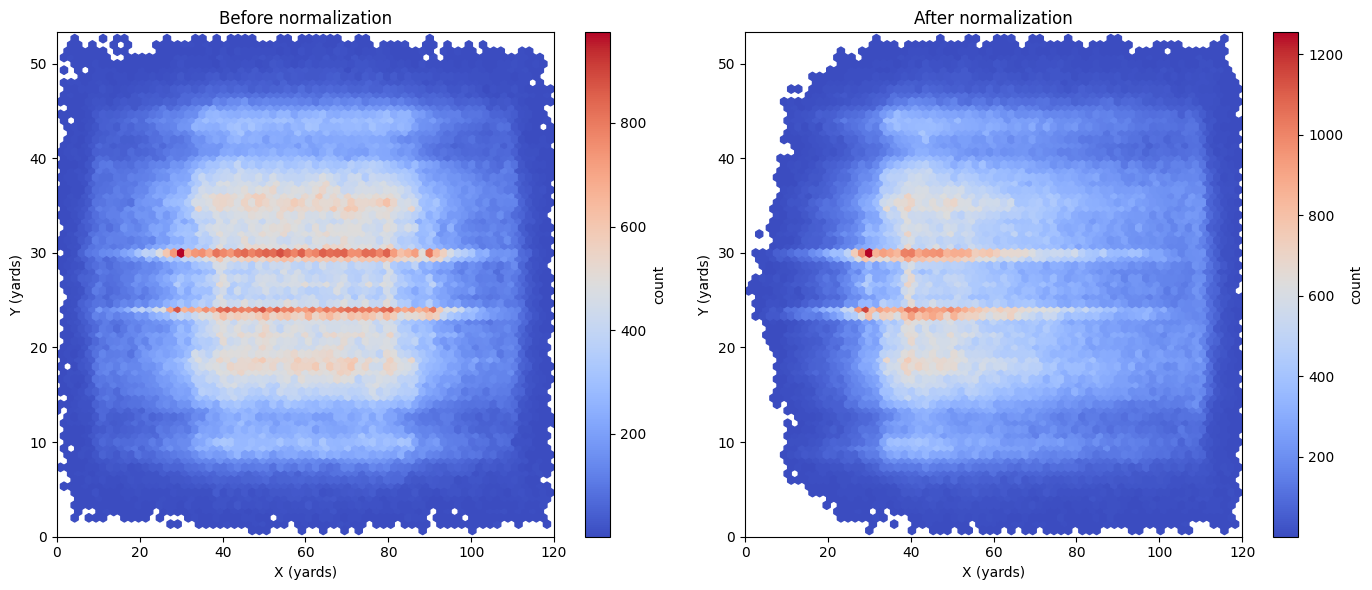

In [24]:
sample_frac = 0.2
idx = eda_df.sample(frac=sample_frac, random_state=17).index
df_orig_sample = eda_df.loc[idx]
df_norm_sample = eda_df_normalized.loc[idx]


plt.figure(figsize=(14, 6))

# Before
plt.subplot(1, 2, 1)
hb1 = plt.hexbin(
    df_orig_sample["x"], df_orig_sample["y"],
    gridsize=70, cmap="coolwarm", extent=(0, 120, 0, 53.3),
    mincnt=1
)
plt.colorbar(hb1, label="count")
plt.title("Before normalization")
plt.xlabel("X (yards)"); plt.ylabel("Y (yards)")
plt.xlim(0, 120); plt.ylim(0, 53.3)


# After
plt.subplot(1, 2, 2)
hb2 = plt.hexbin(
    df_norm_sample["x"], df_norm_sample["y"],
    gridsize=70, cmap="coolwarm", extent=(0, 120, 0, 53.3),
    mincnt=1
)
plt.colorbar(hb2, label="count")
plt.title("After normalization")
plt.xlabel("X (yards)"); plt.ylabel("Y (yards)")
plt.xlim(0, 120); plt.ylim(0, 53.3)

plt.tight_layout()
plt.show()

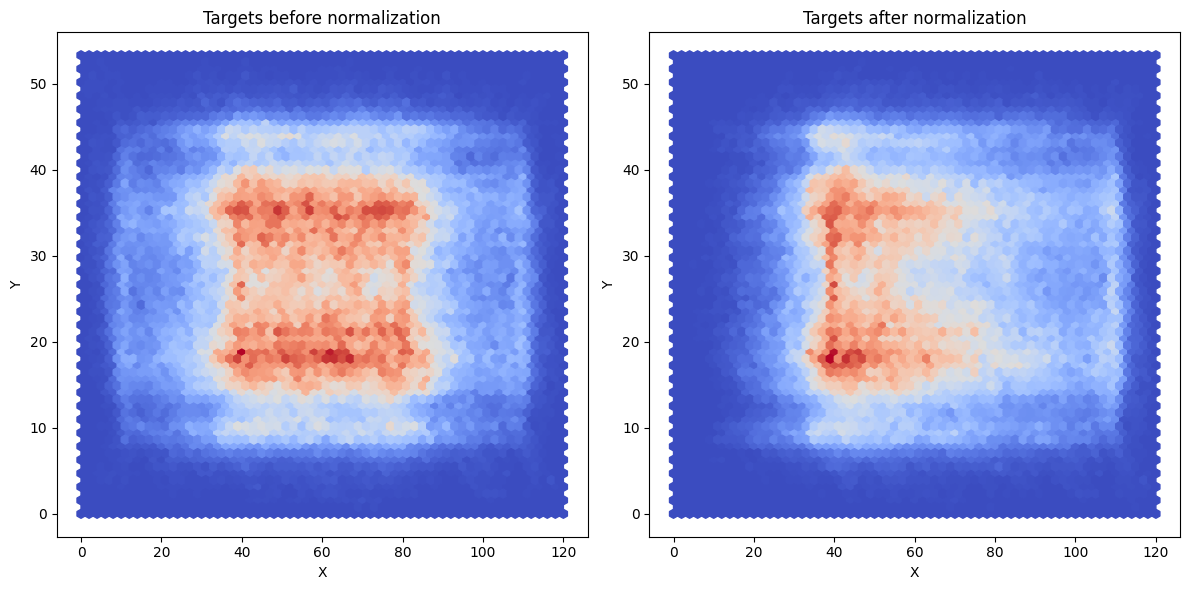

In [25]:
# Targets only

plt.figure(figsize=(12,6))


# Before
plt.subplot(1,2,1)
subset_raw = eda_df[(eda_df["player_to_predict"])]
plt.hexbin(subset_raw["x"], subset_raw["y"], gridsize=60, cmap="coolwarm", extent=(0,120,0,53.3))
plt.title("Targets before normalization")
plt.xlabel("X"); plt.ylabel("Y")


# After
plt.subplot(1,2,2)
subset_norm = eda_df_normalized[(eda_df_normalized["player_to_predict"])]
plt.hexbin(subset_norm["x"], subset_norm["y"], gridsize=60, cmap="coolwarm", extent=(0,120,0,53.3))
plt.title("Targets after normalization")
plt.xlabel("X"); plt.ylabel("Y")

plt.tight_layout()
plt.show()

## After Normalization

### Cleaning

In [26]:
df = eda_df_normalized.copy()

In [27]:
df[["x", "y", "ball_land_x", "ball_land_y", "dir", "o"]].describe()

,x,y,ball_land_x,ball_land_y,dir,o
count,4880579.00000,4880579.00000,4880579.00000,4880579.00000,4880579.00000,4880579.00000
mean,60.82777,26.66587,65.63549,26.00605,130.49296,190.44338
std,23.47994,10.00750,24.66610,15.42471,87.13742,95.63000
min,1.37000,0.42000,7.80000,-4.03000,0.00000,0.00000
25%,42.21000,18.87000,45.94000,12.73000,72.88000,96.82000
50%,57.59000,26.57000,62.89000,25.23000,104.58000,212.08000
75%,77.83000,34.50000,83.57000,39.18000,168.26000,273.27000
max,119.86000,52.86000,125.85000,57.21000,360.00000,360.00000


In [28]:
df = df[df["x"].between(0, X_LIMIT)]
df = df[df["y"].between(0, Y_LIMIT)]

df = df[df["ball_land_x"].between(0, X_LIMIT)]
df = df[df["ball_land_y"].between(0, Y_LIMIT)]

In [29]:
df[["x", "y", "ball_land_x", "ball_land_y", "dir", "o"]].describe()

,x,y,ball_land_x,ball_land_y,dir,o
count,4796906.00000,4796906.00000,4796906.00000,4796906.00000,4796906.00000,4796906.00000
mean,60.68917,26.66669,65.31688,25.99517,130.48871,190.45848
std,23.38448,9.99719,24.51131,15.16228,87.13380,95.63455
min,1.37000,0.42000,7.80000,0.04000,0.00000,0.00000
25%,42.16000,18.87000,45.75000,12.92000,72.90000,96.83000
50%,57.46000,26.56000,62.60000,25.22000,104.57000,212.07000
75%,77.58000,34.49000,83.26000,38.98000,168.24000,273.29000
max,119.86000,52.86000,119.89000,53.28000,360.00000,360.00000


### Kinematic features

Additional physical components of movement.

In [30]:
# Heading to radians
df["dir_rad"] = np.deg2rad(df["dir"])

# Velocity components
df["vx"] = df["s"] * np.cos(df["dir_rad"])
df["vy"] = df["s"] * np.sin(df["dir_rad"])

# Acceleration components
df["ax"] = df["a"] * np.cos(df["dir_rad"])
df["ay"] = df["a"] * np.sin(df["dir_rad"])

# Angle from player to ball landing point and distance
dx_ball = (df["ball_land_x"] - df["x"])
dy_ball = (df["ball_land_y"] - df["y"])
df["dist_to_ball"] = np.sqrt(dx_ball*dx_ball + dy_ball*dy_ball)
df["angle_to_ball"] = np.arctan2(dy_ball, dx_ball)

# Velocity component directed toward the ball
df["v_toward_ball"] = df["vx"] * np.cos(df["angle_to_ball"]) + df["vy"] * np.sin(df["angle_to_ball"])

In [31]:
df[["dir_rad", "vx", "vy", "ax", "ay", "dist_to_ball", "angle_to_ball", "v_toward_ball"]].describe()

,dir_rad,vx,vy,ax,ay,dist_to_ball,angle_to_ball,v_toward_ball
count,4796906.00000,4796906.00000,4796906.00000,4796906.00000,4796906.00000,4796906.00000,4796906.00000,4796906.00000
mean,2.27746,-0.04384,1.74792,-0.02270,1.05844,19.19954,-0.06060,-0.04356
std,1.52077,2.29689,2.39900,1.57524,1.69966,10.62969,1.53217,2.72606
min,0.00000,-10.04920,-10.17635,-11.28319,-14.63068,0.01000,-3.14159,-9.81275
25%,1.27235,-0.99296,0.01817,-0.76439,0.02860,11.01107,-1.39094,-1.47651
50%,1.82509,0.00000,1.29188,0.00000,0.94192,17.63249,-0.15930,0.00000
75%,2.93634,0.89880,3.30051,0.71211,2.08431,25.94675,1.29583,1.36733
max,6.28319,9.75505,10.30911,11.99278,17.07850,73.07823,3.14159,9.97985


### Spatial features

Additional physical components of movement.

In [32]:
# Distance to sidelines/endzone in the normalized frame
df["dist_to_left_sideline"]  = df["y"]  # y grows upward
df["dist_to_right_sideline"] = X_LIMIT - df["y"]  # distance to top boundary
df["dist_to_endzone"] = Y_LIMIT - df["x"]  # moving toward right endzone

# Normalized frame index within predicted horizon (0..1)
den = pd.to_numeric(df["num_frames_output"], errors="coerce").replace(0, np.nan)
df["frame_norm"] = df["frame_id"] / den

In [33]:
df[["dist_to_left_sideline", "dist_to_right_sideline", "dist_to_endzone", "frame_norm"]].describe()

,dist_to_left_sideline,dist_to_right_sideline,dist_to_endzone,frame_norm
count,4796906.00000,4796906.00000,4796906.00000,4796906.00000
mean,26.66669,93.33331,-7.38917,1.60008
std,9.99719,9.99719,23.38448,1.25692
min,0.42000,67.14000,-66.56000,0.01064
25%,18.87000,85.51000,-24.28000,0.66667
50%,26.56000,93.44000,-4.16000,1.33333
75%,34.49000,101.13000,11.14000,2.20000
max,52.86000,119.58000,51.93000,15.37500


### Players data

It might be necessary (but I'm not sure).

In [34]:
# Static player features
def _h_m(h):
    try:
        feet, inch = str(h).split("-")
        return (int(feet)*12 + int(inch)) * 0.0254
    except:
        return np.nan
df["height_m"] = df["player_height"].map(_h_m) # in meters

birth = pd.to_datetime(df["player_birth_date"], errors="coerce")
df["age_years"] = (pd.Timestamp("2025-01-01") - birth).dt.days / 365.25

In [35]:
df[["height_m", "age_years"]].describe()

,height_m,age_years
count,4796906.00000,4796906.00000
mean,1.85595,27.73690
std,0.05725,2.96998
min,1.67640,22.24230
25%,1.82880,25.50856
50%,1.85420,27.31554
75%,1.90500,29.48118
max,2.05740,40.62149


### Team context aggregates (per game_id, play_id, frame_id, side)

The aggregated data reflects the tempo/spacing between frames.
Aggregation by parameters (game_id, play_id, frame_id, player_side) so that offense and defense receive separate summary data at each time step.

In [36]:
group_keys = ["game_id","play_id","frame_id","player_side"]

In [37]:
agg_frame_side = (
    df.groupby(group_keys)
      .agg(
          team_mean_s=("s","mean"),
          team_std_s=("s","std"),
          team_mean_a=("a","mean"),
          team_mean_dist_ball=("dist_to_ball","mean"),
          team_count=("nfl_id","nunique")
      )
      .reset_index()
)

df = df.merge(agg_frame_side, on=group_keys, how="left")

In [38]:
agg_frame_side.head()

,game_id,play_id,frame_id,player_side,team_mean_s,team_std_s,team_mean_a,team_mean_dist_ball,team_count
0,2023090700,194,1,Defense,0.89571,0.76961,0.60143,11.44600,7
1,2023090700,194,1,Offense,0.37167,0.89578,0.22500,12.72833,6
2,2023090700,194,2,Defense,0.87143,0.73088,0.71286,11.44255,7
3,2023090700,194,2,Offense,0.34167,0.81737,0.36000,12.69380,6
4,2023090700,194,3,Defense,0.87286,0.71121,0.76714,11.43588,7


In [39]:
df[["team_mean_s", "team_std_s", "team_mean_a", "team_mean_dist_ball", "team_count"]].describe()

,team_mean_s,team_std_s,team_mean_a,team_mean_dist_ball,team_count
count,4796906.00000,4796871.00000,4796906.00000,4796906.00000,4796906.00000
mean,3.02031,1.35434,2.11808,19.19954,6.27448
std,1.72043,0.76232,0.93815,7.63845,0.83319
min,0.00000,0.00000,0.00000,4.38407,1.00000
25%,1.48750,0.77358,1.54000,13.42700,6.00000
50%,3.18000,1.24710,2.11500,17.70333,6.00000
75%,4.43200,1.87139,2.70667,23.10550,7.00000
max,8.36400,4.93246,6.77200,66.95933,11.00000


### Interaction features: nearest defender distance (for targets only)

Local interactions determine the trajectories of movement. Proximity to the nearest opponent is a predictive factor during the period when the ball is in the air.

In [40]:
CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

In [41]:
weeks_sorted = sorted(df["week"].dropna().unique().tolist())

nearest_parts = [] 

for wk in weeks_sorted:
    cache_path = os.path.join(CACHE_DIR, f"nearest_defender_w{int(wk):02d}.parquet")
    print(f"\n[Week {wk:02d}]")

    # If cache exists, just load and move on
    if os.path.exists(cache_path):
        print(f"Loading from cache: {cache_path}")
        nearest_w = pd.read_parquet(cache_path)
        nearest_parts.append(nearest_w)
        continue

    # Slice week data
    df_w = df[df["week"] == wk]

    # Split targets and defenders
    targets_w  = df_w[df_w["player_to_predict"] == True][
        ["game_id","play_id","frame_id","nfl_id","x","y"]
    ].copy()
    defenders_w = df_w[df_w["player_side"] == "Defense"][
        ["game_id","play_id","frame_id","x","y"]
    ].copy()

    # Early exit if no targets or defenders
    if targets_w.empty or defenders_w.empty:
        print("No targets or defenders in this week; writing empty cache.")
        nearest_w = targets_w[["game_id","play_id","frame_id","nfl_id"]].copy()
        nearest_w["nearest_defender_dist"] = np.nan
        nearest_w.to_parquet(cache_path, index=False)
        nearest_parts.append(nearest_w)
        continue

    # Group by per-frame key to avoid Cartesian explosion
    key_cols = ["game_id","play_id","frame_id"]
    defenders_grp = defenders_w.groupby(key_cols)
    targets_grp   = targets_w.groupby(key_cols)

    # Iterate only over frames that actually have targets
    nearest_chunk_list = []

    # To speed up, prebuild a small dict of defenders per frame (coordinates arrays)
    # and (if KDTree available) build KDTree once per frame.
    # This is memory-savvy because we keep only current frame arrays in scope.
    for key, tg in targets_grp:
        # key is a tuple (gid, pid, fid)
        # defenders in the same frame:
        try:
            def_frame = defenders_grp.get_group(key)
        except KeyError:
            # no defenders in this frame
            tmp = tg[["game_id","play_id","frame_id","nfl_id"]].copy()
            tmp["nearest_defender_dist"] = np.nan
            nearest_chunk_list.append(tmp)
            continue

        # If defenders exist, compute nearest distance for tg -> def_frame
        P = tg[["x","y"]].to_numpy()
        Q = def_frame[["x","y"]].to_numpy()

        if (len(Q) == 0) or (len(P) == 0):
            tmp = tg[["game_id","play_id","frame_id","nfl_id"]].copy()
            tmp["nearest_defender_dist"] = np.nan
            nearest_chunk_list.append(tmp)
            continue

        # Fast nearest neighbor query
        tree = KDTree(Q, leaf_size=32)
        # Query for k=1 nearest defender
        dist, _ = tree.query(P, k=1, return_distance=True)
        dmin = dist.reshape(-1)

        tmp = tg[["game_id","play_id","frame_id","nfl_id"]].copy()
        tmp["nearest_defender_dist"] = dmin
        nearest_chunk_list.append(tmp)

    # Concatenate all frames for this week
    nearest_w = pd.concat(nearest_chunk_list, ignore_index=True)

    # Save to cache
    nearest_w.to_parquet(cache_path, index=False)
    print(f"  -> Saved cache: {cache_path} | rows: {len(nearest_w)}")

    nearest_parts.append(nearest_w)


[Week 01]
Loading from cache: cache\nearest_defender_w01.parquet

[Week 02]
Loading from cache: cache\nearest_defender_w02.parquet

[Week 03]
Loading from cache: cache\nearest_defender_w03.parquet

[Week 04]
Loading from cache: cache\nearest_defender_w04.parquet

[Week 05]
Loading from cache: cache\nearest_defender_w05.parquet

[Week 06]
Loading from cache: cache\nearest_defender_w06.parquet

[Week 07]
Loading from cache: cache\nearest_defender_w07.parquet

[Week 08]
Loading from cache: cache\nearest_defender_w08.parquet

[Week 09]
Loading from cache: cache\nearest_defender_w09.parquet

[Week 10]
Loading from cache: cache\nearest_defender_w10.parquet

[Week 11]
Loading from cache: cache\nearest_defender_w11.parquet

[Week 12]
Loading from cache: cache\nearest_defender_w12.parquet

[Week 13]
Loading from cache: cache\nearest_defender_w13.parquet

[Week 14]
Loading from cache: cache\nearest_defender_w14.parquet

[Week 15]
Loading from cache: cache\nearest_defender_w15.parquet

[Week 16]

In [42]:
nearest_all = pd.concat(nearest_parts, ignore_index=True)
print("All weeks nearest-defender rows:", len(nearest_all))

df = df.merge(
    nearest_all,
    on=["game_id","play_id","frame_id","nfl_id"],
    how="left"
)

All weeks nearest-defender rows: 1281024


In [43]:
targets = df[df["player_to_predict"] == True].copy()

In [44]:
# targets = df[df["player_to_predict"] == True].copy()
# defenders = df[df["player_side"] == "Defense"][["game_id","play_id","frame_id","x","y"]].copy()

# nearest_chunks = []

# for (gid, pid, fid), def_frame in defenders.groupby(["game_id","play_id","frame_id"]):
#     tg = targets[(targets["game_id"]==gid) & (targets["play_id"]==pid) & (targets["frame_id"]==fid)]

#     if tg.empty or def_frame.empty:
#         continue

#     # Pairwise distances (broadcasting)
#     dx = tg["x"].to_numpy()[:,None] - def_frame["x"].to_numpy()[None,:]
#     dy = tg["y"].to_numpy()[:,None] - def_frame["y"].to_numpy()[None,:]
#     d  = np.sqrt(dx*dx + dy*dy)
#     tmp = tg[["game_id", "play_id", "nfl_id", "frame_id"]].copy()
#     tmp["nearest_defender_dist"] = d.min(axis=1)
#     nearest_chunks.append(tmp)

# if len(nearest_chunks):
#     nearest_df = pd.concat(nearest_chunks, ignore_index=True)
#     targets = targets.merge(nearest_df, on=["game_id","play_id","nfl_id","frame_id"], how="left")
# else:
#     targets["nearest_defender_dist"] = np.nan

# print("Nearest-defender feature computed for target rows:", len(targets))

### Mean defender dist to ball (per frame)

The overall density of defensive players in each frame is useful context.

In [45]:
def_df = df[df["player_side"]=="Defense"][["game_id","play_id","frame_id","x","y","ball_land_x","ball_land_y"]].copy()
def_df["dist_ball_def"] = np.sqrt((def_df["ball_land_x"]-def_df["x"])**2 + (def_df["ball_land_y"]-def_df["y"])**2)

def_pressure = (
    def_df.groupby(["game_id","play_id","frame_id"])
          .agg(def_mean_dist_ball=("dist_ball_def","mean"))
          .reset_index()
)

targets = targets.merge(def_pressure, on=["game_id","play_id","frame_id"], how="left")

In [46]:
targets[["nearest_defender_dist", "def_mean_dist_ball"]].describe()

,nearest_defender_dist,def_mean_dist_ball
count,1280989.00000,1280989.00000
mean,1.56500,18.63866
std,2.94957,7.25730
min,0.00000,5.47430
25%,0.00000,12.91984
50%,0.00000,17.06811
75%,1.99905,22.81667
max,36.20018,56.81514


### Final dataframe

Only target rows with all engineered features.


In [47]:
df_ready = targets.copy()

df_ready.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,frame_norm,height_m,age_years,team_mean_s,team_std_s,team_mean_a,team_mean_dist_ball,team_count,nearest_defender_dist,def_mean_dist_ball
0,2023090700,361,True,46137,1,right,22,Justin Reid,6-1,204,...,0.06250,1.85420,27.87680,0.95500,0.75270,0.78000,23.82987,6,0.00000,23.82987
1,2023090700,361,True,46137,2,right,22,Justin Reid,6-1,204,...,0.12500,1.85420,27.87680,0.95500,0.78973,0.94000,23.90210,6,0.00000,23.90210
2,2023090700,361,True,46137,3,right,22,Justin Reid,6-1,204,...,0.18750,1.85420,27.87680,1.00000,0.84401,1.13500,23.96322,6,0.00000,23.96322
3,2023090700,361,True,46137,4,right,22,Justin Reid,6-1,204,...,0.25000,1.85420,27.87680,1.14667,0.88602,1.39167,24.01785,6,0.00000,24.01785
4,2023090700,361,True,46137,5,right,22,Justin Reid,6-1,204,...,0.31250,1.85420,27.87680,1.32167,0.89450,1.58000,24.06781,6,0.00000,24.06781


In [48]:
df_ready.shape

(1281024, 46)

In [49]:
df_ready.iloc[0]

game_id                             2023090700
play_id                                    361
player_to_predict                         True
nfl_id                                   46137
frame_id                                     1
play_direction                           right
absolute_yardline_number                    22
player_name                        Justin Reid
player_height                              6-1
player_weight                              204
player_birth_date                   1997-02-15
player_position                             SS
player_side                            Defense
player_role                 Defensive Coverage
x                                     33.39000
y                                     35.12000
s                                      0.79000
a                                      1.72000
dir                                  200.79000
o                                    246.56000
num_frames_output                           16
ball_land_x  

## Visualizations

### Speed and Acceleration histograms

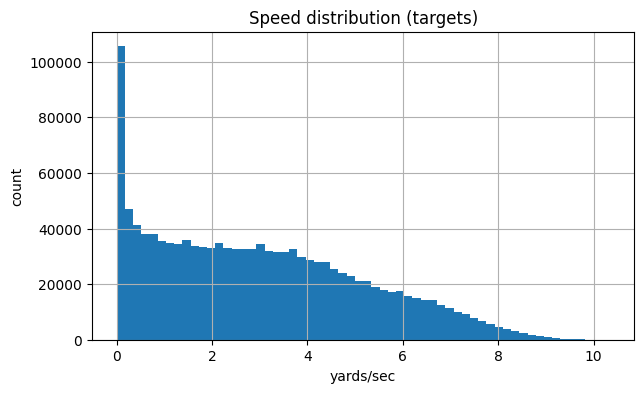

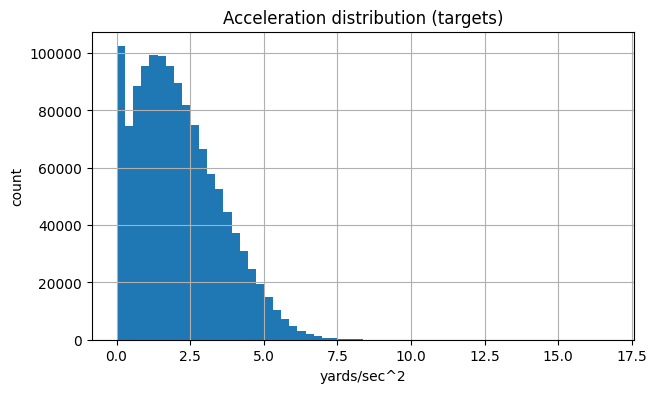

In [50]:
plt.figure(figsize=(7,4))
df_ready["s"].hist(bins=60)
plt.title("Speed distribution (targets)"); plt.xlabel("yards/sec"); plt.ylabel("count")
plt.show()

plt.figure(figsize=(7,4))
df_ready["a"].hist(bins=60)
plt.title("Acceleration distribution (targets)"); plt.xlabel("yards/sec^2"); plt.ylabel("count")
plt.show()

### Distance to ball vs velocity toward ball (sampled scatter)

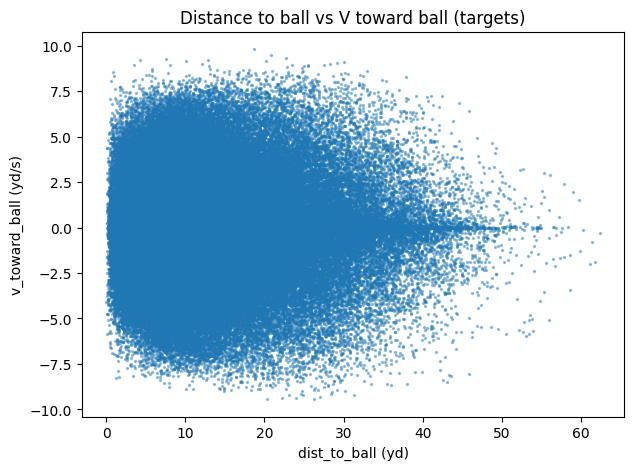

In [51]:
plot_sample = df_ready.sample(frac=0.15, random_state=42) if len(df_ready) > 200_000 else df_ready
plt.figure(figsize=(7,5))
plt.scatter(plot_sample["dist_to_ball"], plot_sample["v_toward_ball"], s=2, alpha=0.4, rasterized=True)
plt.title("Distance to ball vs V toward ball (targets)")
plt.xlabel("dist_to_ball (yd)"); plt.ylabel("v_toward_ball (yd/s)")
plt.show()

### Field density (hexbin) for targets after normalization

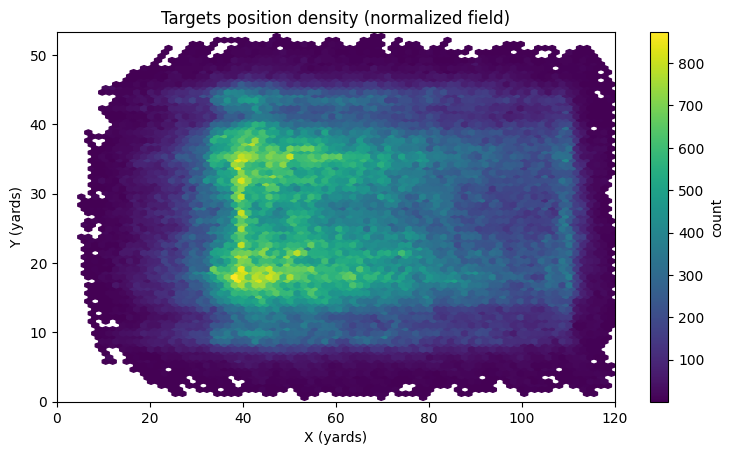

In [52]:
plt.figure(figsize=(9,4.8))
hb = plt.hexbin(df_ready["x"], df_ready["y"], gridsize=80, extent=(0,120,0,53.3), mincnt=1, cmap="viridis")
plt.colorbar(hb, label="count")
plt.title("Targets position density (normalized field)")
plt.xlabel("X (yards)"); plt.ylabel("Y (yards)")
plt.xlim(0,120); plt.ylim(0,53.3)
plt.show()


### Correlations overview of key engineered features

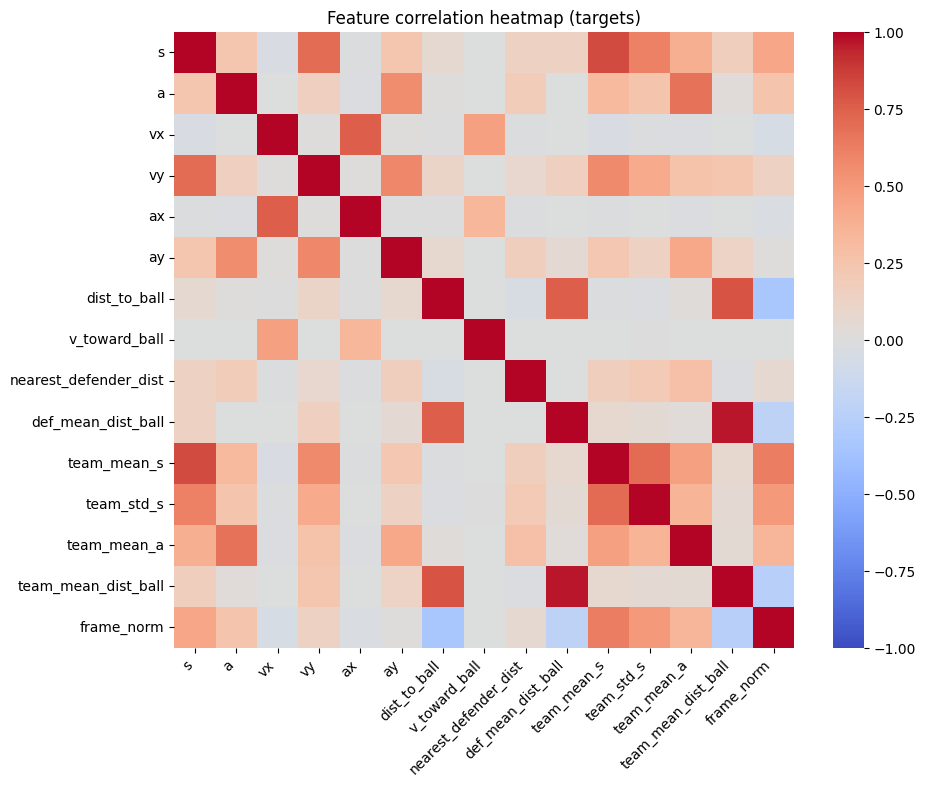

In [53]:
corr_cols = [
    "s","a","vx","vy","ax","ay",
    "dist_to_ball","v_toward_ball",
    "nearest_defender_dist","def_mean_dist_ball",
    "team_mean_s","team_std_s","team_mean_a","team_mean_dist_ball",
    "frame_norm"
]

corr = df_ready[corr_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", annot=False, vmin=-1, vmax=1)
plt.title("Feature correlation heatmap (targets)")
plt.xticks(rotation=45, ha='right')
plt.show()

## Advanced feature engineering (for targets only)

1. time_to_ball — distance / speed (ETA proxy)
2. v_rel_to_ball — fraction of speed pointed to the ball
3. heading alignment — how aligned the player motion is toward the ball
4. pressure_index — inverse distance to nearest defender (bigger = tighter)
5. normalized coords — x_norm, y_norm (0..1) for scale-free learning


In [54]:
eps = 1e-3

# Filter out stationary players
df_ready_filtered = df_ready[df_ready["s"] > 0.3].copy()

### Time-to-ball, relative velocity

In [55]:
df_ready_filtered["time_to_ball"]  = df_ready_filtered["dist_to_ball"] / (df_ready_filtered["s"] + eps)
df_ready_filtered["v_rel_to_ball"] = df_ready_filtered["v_toward_ball"] / (df_ready_filtered["s"] + eps)

ttb_clip = df_ready_filtered["time_to_ball"].quantile(0.99) # clip extreme tail (99th percentile)
df_ready_filtered["time_to_ball"] = df_ready_filtered["time_to_ball"].clip(0, ttb_clip)
df_ready_filtered["log_time_to_ball"] = np.log1p(df_ready_filtered["time_to_ball"])

df_ready_filtered["v_rel_to_ball"] = df_ready_filtered["v_rel_to_ball"].clip(-1.0, 1.0)

In [56]:
df_ready_filtered["time_to_ball"].describe()

count   1138547.00000
mean          6.55696
std           8.34384
min           0.00283
25%           1.92915
50%           3.60559
75%           7.31549
max          48.81945
Name: time_to_ball, dtype: float64

### Heading alignment (cosine of angle difference)

In [57]:
# cos() = 1 means "fully toward the ball", -1 means "fully away"
df_ready_filtered["angle_diff"] = df_ready_filtered["dir_rad"] - df_ready_filtered["angle_to_ball"]

# wrap to [-pi, pi] for numerical stability
df_ready_filtered["angle_diff"] = (df_ready_filtered["angle_diff"] + np.pi) % (2*np.pi) - np.pi
df_ready_filtered["cos_to_ball"] = np.cos(df_ready_filtered["angle_diff"])
df_ready_filtered["sin_to_ball"] = np.sin(df_ready_filtered["angle_diff"])

### Pressure index (the smaller the distance, the bigger the pressure)

In [58]:
df_ready_filtered["pressure_index"] = 1.0 / (df_ready_filtered["nearest_defender_dist"].fillna(10.0) + 0.5)

df_ready_filtered["pressure_index"] = df_ready_filtered["pressure_index"].clip(0, 5)
df_ready_filtered["pressure_index_norm"] = df_ready_filtered["pressure_index"] / df_ready_filtered["pressure_index"].max()

### Normalized coordinates [0, 1]

In [59]:
df_ready_filtered["x_norm"] = df_ready_filtered["x"] / X_LIMIT
df_ready_filtered["y_norm"] = df_ready_filtered["y"] / Y_LIMIT

### Simple forward-progress proxies
A positive value for vx indicates movement to the right (down the field after normalization).

In [60]:
df_ready_filtered["is_moving_forward"] = (df_ready_filtered["vx"] > 0).astype(np.int8)
df_ready_filtered["forward_speed"] = df_ready_filtered["vx"].clip(lower=0.0)  # only downfield component

### Additional cleaning

In [61]:
df_ready_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)

# Moderate outlier removal (prevents scale distortion due to incorrect sensor readings)
df_ready_filtered = df_ready_filtered[(df_ready_filtered["s"] <= 12) & (df_ready_filtered["a"] <= 15)]
df_ready_filtered.dropna(inplace=True)

In [62]:
df_ready_filtered[["time_to_ball", "log_time_to_ball", "v_rel_to_ball", "angle_diff", "cos_to_ball", "sin_to_ball",
    "pressure_index", "pressure_index_norm", "x_norm", "y_norm", "is_moving_forward", "forward_speed"]].describe()

,time_to_ball,log_time_to_ball,v_rel_to_ball,angle_diff,cos_to_ball,sin_to_ball,pressure_index,pressure_index_norm,x_norm,y_norm,is_moving_forward,forward_speed
count,1138514.00000,1138514.00000,1138514.00000,1138514.00000,1138514.00000,1138514.00000,1138514.00000,1138514.00000,1138514.00000,1138514.00000,1138514.00000,1138514.00000
mean,6.55689,1.65687,-0.00631,0.05962,-0.00631,0.02717,1.46560,0.73280,0.52222,0.49574,0.48397,0.88004
std,8.34388,0.79123,0.70220,1.81621,0.70258,0.71106,0.80734,0.40367,0.19345,0.19091,0.49974,1.48356
min,0.00283,0.00283,-0.99989,-3.14159,-1.00000,-1.00000,0.02725,0.01362,0.04383,0.01163,0.00000,0.00000
25%,1.92912,1.07470,-0.70333,-1.52941,-0.70369,-0.69371,0.40723,0.20361,0.36658,0.34053,0.00000,0.00000
50%,3.60547,1.52724,-0.01419,0.13454,-0.01419,0.06632,2.00000,1.00000,0.49525,0.48968,0.00000,0.00000
75%,7.31522,2.11809,0.69150,1.63858,0.69189,0.73612,2.00000,1.00000,0.66175,0.65310,1.00000,1.23363
max,48.81945,3.90841,0.99989,3.14159,1.00000,1.00000,2.00000,1.00000,0.99600,0.98724,1.00000,9.58966


## Additional visualizations

### time_to_ball distribution

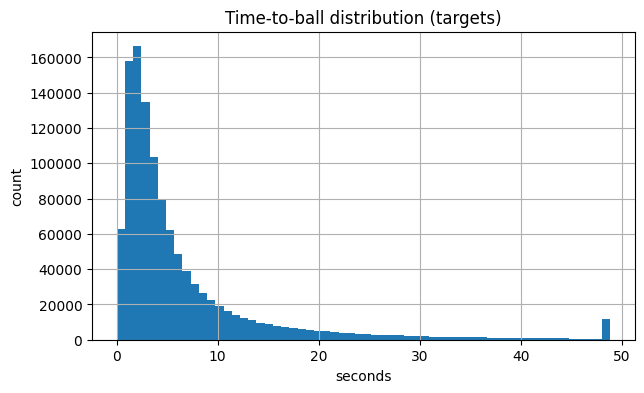

In [63]:
plt.figure(figsize=(7,4))
df_ready_filtered["time_to_ball"].hist(bins=60)
plt.title("Time-to-ball distribution (targets)")
plt.xlabel("seconds"); plt.ylabel("count")
plt.show()

### v_rel_to_ball (should cluster in [-1, 1])

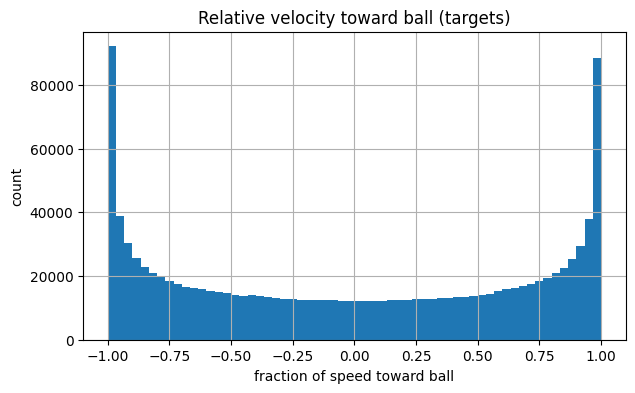

In [64]:
plt.figure(figsize=(7,4))
df_ready_filtered["v_rel_to_ball"].hist(bins=60)
plt.title("Relative velocity toward ball (targets)")
plt.xlabel("fraction of speed toward ball"); plt.ylabel("count")
plt.show()

### Alignment vs distance: players closer to the ball should be more aligned (cos_to_ball ~ 1)

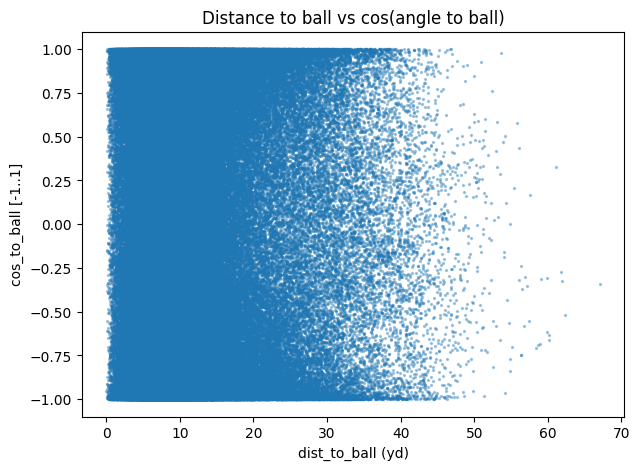

In [65]:
samp = df_ready_filtered.sample(frac=0.15, random_state=7) if len(df_ready_filtered) > 200_000 else df_ready_filtered
plt.figure(figsize=(7,5))
plt.scatter(samp["dist_to_ball"], samp["cos_to_ball"], s=2, alpha=0.35, rasterized=True)
plt.title("Distance to ball vs cos(angle to ball)")
plt.xlabel("dist_to_ball (yd)"); plt.ylabel("cos_to_ball [-1..1]")
plt.show()

### Pressure heat on field

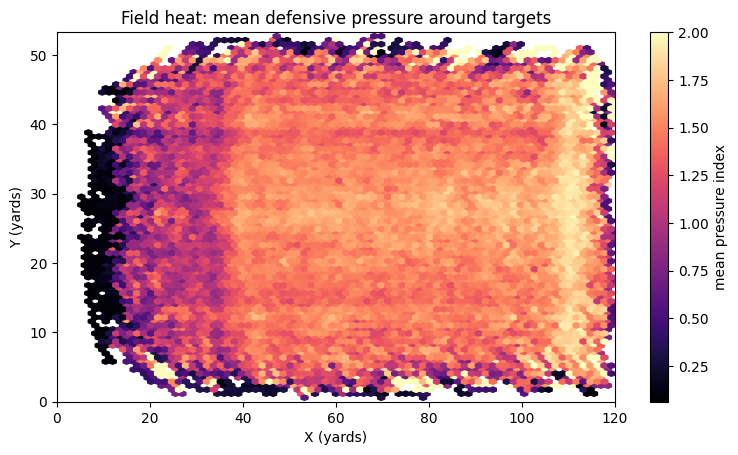

In [66]:
plt.figure(figsize=(9,4.8))
hb = plt.hexbin(
    df_ready_filtered["x"], df_ready_filtered["y"],
    C=df_ready_filtered["pressure_index"], reduce_C_function=np.mean,
    gridsize=80, extent=(0,120,0,53.3), mincnt=1, cmap="magma"
)
plt.colorbar(hb, label="mean pressure index")
plt.title("Field heat: mean defensive pressure around targets")
plt.xlabel("X (yards)"); plt.ylabel("Y (yards)")
plt.xlim(0,120); plt.ylim(0,53.3)
plt.show()

### Time-to-ball vs pressure (should trend: high pressure -> lower time)

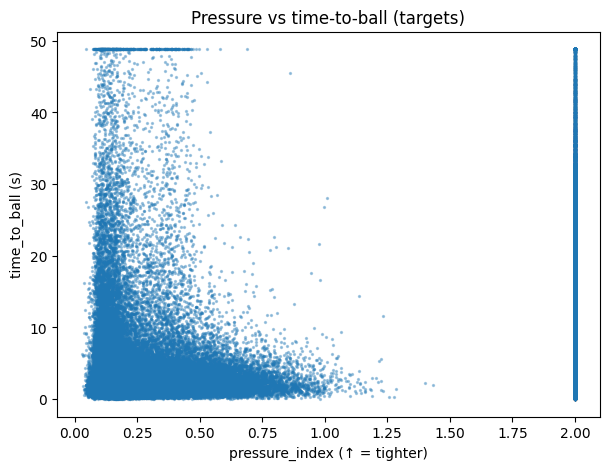

In [67]:
plt.figure(figsize=(7,5))
plt.scatter(samp["pressure_index"], samp["time_to_ball"], s=2, alpha=0.35, rasterized=True)
plt.title("Pressure vs time-to-ball (targets)")
plt.xlabel("pressure_index (↑ = tighter)"); plt.ylabel("time_to_ball (s)")
plt.show()

## Save features

In [68]:
feature_cols = [
    # identifiers
    "game_id", "play_id", "nfl_id", "frame_id", "week",

    # positions / motion
    "x", "y", "s", "a", "dir", "o", "dir_rad", "vx", "vy", "ax", "ay",

    # ball geometry
    "dist_to_ball", "angle_to_ball", "v_toward_ball",

    # advanced features
    "time_to_ball", "log_time_to_ball", "v_rel_to_ball", "angle_diff", "cos_to_ball", "sin_to_ball",
    "pressure_index", "pressure_index_norm", "x_norm", "y_norm", "is_moving_forward", "forward_speed",

    # team context
    "team_mean_s", "team_std_s", "team_mean_a", "team_mean_dist_ball", "team_count",

    # extra spatial
    "dist_to_left_sideline", "dist_to_right_sideline", "dist_to_endzone", "frame_norm",

    # optional player data
    "height_m", "age_years", "player_position", "player_role", "player_side"
]

df_ready_filtered[feature_cols].to_parquet(f"{RESULTS_DIR}/targets_features_advanced_ALL.parquet", index=False, engine='fastparquet')

# Modelling

## Data preparation

In [69]:
outputs = pd.concat(OUTPUT_DFS, ignore_index=True)

outputs.shape

(562936, 7)

In [70]:
# take the last input frame per player (t0 before throw)
t0 = (
    df_ready_filtered
    .sort_values("frame_id")
    .groupby(["game_id","play_id","nfl_id", "week"], as_index=False)
    .tail(1)
    .copy()
)

In [71]:
t0 = t0.rename(columns={
    "frame_id": "frame_id_in",
    "x": "x0",
    "y": "y0",
})

In [72]:
outputs_renamed = outputs.rename(columns={
    "frame_id": "frame_id_out",
    "x": "x_out", 
    "y": "y_out",
})

In [73]:
data = t0.merge(
    outputs_renamed,
    on=["game_id", "play_id", "nfl_id", "week"],
    how="inner",
)


In [74]:
print("t0 shape:", t0.shape, "outputs shape:", outputs_renamed.shape, "merged shape:", data.shape)

t0 shape: (45287, 58) outputs shape: (562936, 7) merged shape: (548217, 61)


In [75]:
data.groupby(["game_id","play_id","nfl_id"])["frame_id_out"].nunique().describe()

count   45287.00000
mean       12.10539
std         5.46605
min         5.00000
25%         8.00000
50%        10.00000
75%        14.00000
max        94.00000
Name: frame_id_out, dtype: float64

In [76]:
data.columns

Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id_in',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x0', 'y0', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'week',
       'was_left', 'dir_rad', 'vx', 'vy', 'ax', 'ay', 'dist_to_ball',
       'angle_to_ball', 'v_toward_ball', 'dist_to_left_sideline',
       'dist_to_right_sideline', 'dist_to_endzone', 'frame_norm', 'height_m',
       'age_years', 'team_mean_s', 'team_std_s', 'team_mean_a',
       'team_mean_dist_ball', 'team_count', 'nearest_defender_dist',
       'def_mean_dist_ball', 'time_to_ball', 'v_rel_to_ball',
       'log_time_to_ball', 'angle_diff', 'cos_to_ball', 'sin_to_ball',
       'pressure_index', 'pressure_index_norm', 'x_norm', 'y_norm',
       'is_moving_forward', 'forward_speed', 'frame_id_out', 'x_out', 'y_out'],
      dtype

In [77]:
# Don't forget to normalize the output also!
mask = data["was_left"] == 1
data.loc[mask, "x_out"] = X_LIMIT - data.loc[mask, "x_out"]
data.loc[mask, "y_out"] = Y_LIMIT - data.loc[mask, "y_out"]

In [78]:
# Target values: displacement from time point t0 to each output frame
data["target_dx"] = data["x_out"] - data["x0"]
data["target_dy"] = data["y_out"] - data["y0"]

In [79]:
# Remove unnecessary columns
exclude_cols = [
    "player_name", "player_position", "player_role", "player_side", "play_direction",
    "player_height", "player_birth_date",
    "game_id", "play_id", "nfl_id",
    "x_out", "y_out", "frame_id_in", "frame_id_out",
    "target_dx", "target_dy",
]

feature_cols = [c for c in data.columns if c not in exclude_cols]

feature_cols

['player_to_predict',
 'absolute_yardline_number',
 'player_weight',
 'x0',
 'y0',
 's',
 'a',
 'dir',
 'o',
 'num_frames_output',
 'ball_land_x',
 'ball_land_y',
 'week',
 'was_left',
 'dir_rad',
 'vx',
 'vy',
 'ax',
 'ay',
 'dist_to_ball',
 'angle_to_ball',
 'v_toward_ball',
 'dist_to_left_sideline',
 'dist_to_right_sideline',
 'dist_to_endzone',
 'frame_norm',
 'height_m',
 'age_years',
 'team_mean_s',
 'team_std_s',
 'team_mean_a',
 'team_mean_dist_ball',
 'team_count',
 'nearest_defender_dist',
 'def_mean_dist_ball',
 'time_to_ball',
 'v_rel_to_ball',
 'log_time_to_ball',
 'angle_diff',
 'cos_to_ball',
 'sin_to_ball',
 'pressure_index',
 'pressure_index_norm',
 'x_norm',
 'y_norm',
 'is_moving_forward',
 'forward_speed']

In [80]:
X = data[feature_cols]
y_dx = data["target_dx"]
y_dy = data["target_dy"]
groups = data["game_id"]

In [81]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548217 entries, 0 to 548216
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   player_to_predict         548217 non-null  bool   
 1   absolute_yardline_number  548217 non-null  int64  
 2   player_weight             548217 non-null  int64  
 3   x0                        548217 non-null  float64
 4   y0                        548217 non-null  float64
 5   s                         548217 non-null  float64
 6   a                         548217 non-null  float64
 7   dir                       548217 non-null  float64
 8   o                         548217 non-null  float64
 9   num_frames_output         548217 non-null  int64  
 10  ball_land_x               548217 non-null  float64
 11  ball_land_y               548217 non-null  float64
 12  week                      548217 non-null  int64  
 13  was_left                  548217 non-null  i

In [82]:
Xc = X.copy()

Xc["player_to_predict"] = Xc["player_to_predict"].astype(np.int8)

In [83]:
Xc = Xc.astype(np.float32)

Xc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548217 entries, 0 to 548216
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   player_to_predict         548217 non-null  float32
 1   absolute_yardline_number  548217 non-null  float32
 2   player_weight             548217 non-null  float32
 3   x0                        548217 non-null  float32
 4   y0                        548217 non-null  float32
 5   s                         548217 non-null  float32
 6   a                         548217 non-null  float32
 7   dir                       548217 non-null  float32
 8   o                         548217 non-null  float32
 9   num_frames_output         548217 non-null  float32
 10  ball_land_x               548217 non-null  float32
 11  ball_land_y               548217 non-null  float32
 12  week                      548217 non-null  float32
 13  was_left                  548217 non-null  f

In [84]:
Xc.describe().iloc[:, :10]

,player_to_predict,absolute_yardline_number,player_weight,x0,y0,s,a,dir,o,num_frames_output
count,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000
mean,1.00000,60.40857,208.52213,66.84444,26.48876,4.80124,2.73515,114.12220,208.44183,14.57347
std,0.00000,22.96418,21.79147,22.86065,11.69396,2.05421,1.46741,78.73947,100.13211,7.15000
min,1.00000,11.00000,153.00000,7.44000,0.69000,0.31000,0.02000,0.00000,0.00000,5.00000
25%,1.00000,41.00000,193.00000,48.43000,16.34000,3.28000,1.58000,59.78000,136.59000,9.00000
50%,1.00000,60.00000,203.00000,64.38000,26.29000,4.75000,2.55000,101.44000,233.94000,13.00000
75%,1.00000,79.00000,221.00000,84.11000,36.69000,6.34000,3.74000,151.03000,285.67999,18.00000
max,1.00000,109.00000,358.00000,119.39000,52.62000,10.34000,8.36000,360.00000,359.97000,94.00000


In [85]:
Xc.describe().iloc[:, 10:20]

,ball_land_x,ball_land_y,week,was_left,dir_rad,vx,vy,ax,ay,dist_to_ball
count,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000
mean,71.34570,26.50547,9.51637,0.49659,1.99181,-0.05693,2.85707,-0.02577,1.45445,11.59384
std,24.67689,16.16193,5.26963,0.49999,1.37426,3.51112,2.60339,2.16910,1.67728,7.39095
min,7.80000,0.04000,1.00000,0.00000,0.00000,-10.04920,-6.34247,-8.14000,-7.37826,0.02236
25%,51.43000,11.73000,5.00000,0.00000,1.04336,-2.65839,0.99003,-1.46574,0.44260,6.17778
50%,69.60000,26.11000,10.00000,0.00000,1.77046,-0.03329,2.73081,-0.01277,1.36321,9.57648
75%,90.70000,41.43000,14.00000,1.00000,2.63597,2.53580,4.63187,1.40027,2.46579,15.63003
max,119.89000,53.28000,18.00000,1.00000,6.28319,9.58966,10.30911,8.07594,8.23673,49.74038


In [86]:
Xc.describe().iloc[:, 20:30]

,angle_to_ball,v_toward_ball,dist_to_left_sideline,dist_to_right_sideline,dist_to_endzone,frame_norm,height_m,age_years,team_mean_s,team_std_s
count,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000
mean,-0.00616,0.05022,26.48876,93.51125,-13.54444,2.33619,1.84893,27.65967,4.35806,1.86780
std,1.55449,3.60070,11.69396,11.69396,22.86065,1.07250,0.05299,2.84003,0.99695,0.67443
min,-3.14159,-9.57764,0.69000,67.38000,-66.09000,0.27660,1.67640,22.24230,0.39333,0.17039
25%,-1.31700,-2.70023,16.34000,83.31000,-30.81000,1.59091,1.80340,25.50034,3.65000,1.35529
50%,-0.00068,0.06632,26.29000,93.71000,-11.08000,2.15385,1.85420,27.29090,4.34714,1.80595
75%,1.27874,2.80539,36.69000,103.66000,4.87000,2.83333,1.87960,29.43737,5.04714,2.34034
max,3.14159,9.81278,52.62000,119.31000,45.86000,15.37500,2.05740,40.62149,8.31200,4.85027


In [87]:
Xc.describe().iloc[:, 30:46]

,team_mean_a,team_mean_dist_ball,team_count,nearest_defender_dist,def_mean_dist_ball,time_to_ball,v_rel_to_ball,log_time_to_ball,angle_diff,cos_to_ball,sin_to_ball,pressure_index,pressure_index_norm,x_norm,y_norm,is_moving_forward
count,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000,548217.00000
mean,2.46612,20.30223,6.36621,1.15211,20.05283,3.09859,0.00916,1.22536,-0.25353,0.00917,-0.13141,1.52415,0.76208,0.55704,0.49697,0.49620
std,0.59688,7.44354,0.87196,2.46871,6.95727,3.53308,0.69735,0.55304,1.77708,0.69755,0.70432,0.76226,0.38113,0.19051,0.21940,0.49999
min,0.45000,5.56986,2.00000,0.00000,7.00098,0.00731,-0.99988,0.00728,-3.14135,-1.00000,-1.00000,0.03868,0.01934,0.06200,0.01295,0.00000
25%,2.05000,14.30634,6.00000,0.00000,14.28778,1.29010,-0.67618,0.82860,-1.74663,-0.67647,-0.81849,0.60002,0.30001,0.40358,0.30657,0.00000
50%,2.42571,18.92050,7.00000,0.00000,19.10331,2.21518,0.01977,1.16788,-0.51158,0.01977,-0.26515,2.00000,1.00000,0.53650,0.49325,0.00000
75%,2.84500,24.70352,7.00000,1.16662,24.38717,3.55549,0.69854,1.51633,1.19932,0.69864,0.56515,2.00000,1.00000,0.70092,0.68837,1.00000
max,5.49833,52.10954,11.00000,25.35292,47.41971,48.81945,0.99989,3.90841,3.14146,1.00000,1.00000,2.00000,1.00000,0.99492,0.98724,1.00000


In [88]:
Xc.isna().sum()

player_to_predict           0
absolute_yardline_number    0
player_weight               0
x0                          0
y0                          0
s                           0
a                           0
dir                         0
o                           0
num_frames_output           0
ball_land_x                 0
ball_land_y                 0
week                        0
was_left                    0
dir_rad                     0
vx                          0
vy                          0
ax                          0
ay                          0
dist_to_ball                0
angle_to_ball               0
v_toward_ball               0
dist_to_left_sideline       0
dist_to_right_sideline      0
dist_to_endzone             0
frame_norm                  0
height_m                    0
age_years                   0
team_mean_s                 0
team_std_s                  0
team_mean_a                 0
team_mean_dist_ball         0
team_count                  0
nearest_de

In [89]:
np.isinf(Xc).sum()

player_to_predict           0
absolute_yardline_number    0
player_weight               0
x0                          0
y0                          0
s                           0
a                           0
dir                         0
o                           0
num_frames_output           0
ball_land_x                 0
ball_land_y                 0
week                        0
was_left                    0
dir_rad                     0
vx                          0
vy                          0
ax                          0
ay                          0
dist_to_ball                0
angle_to_ball               0
v_toward_ball               0
dist_to_left_sideline       0
dist_to_right_sideline      0
dist_to_endzone             0
frame_norm                  0
height_m                    0
age_years                   0
team_mean_s                 0
team_std_s                  0
team_mean_a                 0
team_mean_dist_ball         0
team_count                  0
nearest_de

In [90]:
y_dx.head(), y_dy.head() 

(0   -0.01000
 1   -0.08000
 2   -0.19000
 3   -0.36000
 4   -0.56000
 Name: target_dx, dtype: float64,
 0   0.02000
 1   0.08000
 2   0.17000
 3   0.29000
 4   0.43000
 Name: target_dy, dtype: float64)

In [91]:
y_dx.isna().sum(), y_dy.isna().sum()

(np.int64(0), np.int64(0))

In [92]:
np.isinf(y_dx).sum(), np.isinf(y_dy).sum()

(np.int64(0), np.int64(0))

In [93]:
y_dx_c = y_dx.astype(np.float32)
y_dy_c = y_dy.astype(np.float32)

In [94]:
groups.unique()[:10]

array([2023112604, 2023111211, 2023091712, 2023092410, 2023111906,
       2023091700, 2023121705, 2023110509, 2023091004, 2023121007])

In [95]:
groups.isna().sum(), np.isinf(groups).sum()

(np.int64(0), np.int64(0))

In [96]:
groups_c = groups.astype(np.float32)

## Cross-validation training (LightGBM)

In [ ]:
lgb_params = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "learning_rate": 0.05, # the step size, how much to weigh each sequential tree's prediction
    "num_leaves": 64, # stop each tree when there are 64 leaves 
    "feature_fraction": 0.8, # sample 80% of the features to use as nodes 
    "bagging_fraction": 0.8, # sample 80% of the samples (without replacement)
    "bagging_freq": 3, # resample the samples every 3 iterations 
    "n_estimators": 2000, # number of trees 
    "random_state": 42,
    "verbose": -1, # do not print the output 
}

gkf = GroupKFold(n_splits=5)
metrics = []
models_dx, models_dy = [], []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(Xc, y_dx_c, groups_c)):
    print(f"\nFold {fold+1}/5")

    Xtr, Xva = Xc.iloc[tr_idx], Xc.iloc[va_idx]
    ydx_tr, ydx_va = y_dx_c.iloc[tr_idx], y_dx_c.iloc[va_idx]
    ydy_tr, ydy_va = y_dy_c.iloc[tr_idx], y_dy_c.iloc[va_idx]

    # common callbacks (early stopping + logging)
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=50)
    ]

    # dx
    m_dx = lgb.LGBMRegressor(**lgb_params)
    m_dx.fit(
        Xtr, ydx_tr,
        eval_set=[(Xva, ydx_va)],
        eval_metric="rmse",
        callbacks=callbacks
    )
    best_it_dx = m_dx.best_iteration_ if getattr(m_dx, "best_iteration_", None) else lgb_params["n_estimators"]
    p_dx = m_dx.predict(Xva, num_iteration=best_it_dx)
    models_dx.append(m_dx)

    # dy
    m_dy = lgb.LGBMRegressor(**lgb_params)
    m_dy.fit(
        Xtr, ydy_tr,
        eval_set=[(Xva, ydy_va)],
        eval_metric="rmse",
        callbacks=callbacks
    )
    best_it_dy = m_dy.best_iteration_ if getattr(m_dy, "best_iteration_", None) else lgb_params["n_estimators"]
    p_dy = m_dy.predict(Xva, num_iteration=best_it_dy)
    models_dy.append(m_dy)

    mae_x = mean_absolute_error(ydx_va, p_dx)
    mae_y = mean_absolute_error(ydy_va, p_dy)

    rmse_x = np.sqrt(mean_squared_error(ydx_va, p_dx))
    rmse_y = np.sqrt(mean_squared_error(ydy_va, p_dy))

    metrics.append((mae_x, mae_y, rmse_x, rmse_y))
    print(f"MAE dx={mae_x:.3f},  MAE dy={mae_y:.3f}, RMSE dx={rmse_x:.3f}, RMSE dy={rmse_y:.3f}")

metrics = np.array(metrics)
print("\nSummary")
print(f"MAE dx:  {metrics[:,0].mean():.3f} ± {metrics[:,0].std():.3f}")
print(f"MAE dy:  {metrics[:,1].mean():.3f} ± {metrics[:,1].std():.3f}")
print(f"RMSE dx: {metrics[:,2].mean():.3f} ± {metrics[:,2].std():.3f}")
print(f"RMSE dy: {metrics[:,3].mean():.3f} ± {metrics[:,3].std():.3f}")

## Restore predicted coordinates on the last fold's validation set

In [ ]:
va_idx_last = list(gkf.split(X, y_dx, groups))[-1][1]
data_val = data.iloc[va_idx_last].copy()

data_val["pred_dx"] = models_dx[-1].predict(X.iloc[va_idx_last])
data_val["pred_dy"] = models_dy[-1].predict(X.iloc[va_idx_last])

data_val["x_pred"] = data_val["x0"] + data_val["pred_dx"]
data_val["y_pred"] = data_val["y0"] + data_val["pred_dy"]

## Visualizations checks

### Scatter predicted vs true displacements

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(data_val["target_dx"], data_val["pred_dx"], s=6, alpha=0.3)
plt.axline((0,0),(1,1), color="gray", linestyle="--")
plt.xlabel("True dx"); plt.ylabel("Pred dx")
plt.title("Predicted vs True dx (last fold)")
plt.show()


plt.figure(figsize=(6,5))
plt.scatter(data_val["target_dy"], data_val["pred_dy"], s=6, alpha=0.3)
plt.axline((0,0),(1,1), color="gray", linestyle="--")
plt.xlabel("True dy"); plt.ylabel("Pred dy")
plt.title("Predicted vs True dy (last fold)")
plt.show()

### Field scatter: true vs predicted coordinates

In [ ]:
sample = data_val.sample(n=min(5000, len(data_val)), random_state=17)

plt.figure(figsize=(10,5))
plt.scatter(sample["x_out"], sample["y_out"], s=6, alpha=0.35, label="True", c="tab:blue")
plt.scatter(sample["x_pred"], sample["y_pred"], s=6, alpha=0.35, label="Pred", c="tab:red")
plt.xlim(0,120); plt.ylim(0,53.3)
plt.xlabel("X (yards)"); plt.ylabel("Y (yards)")
plt.title("True vs Predicted player positions (sample, last CV fold)")
plt.legend()
plt.show()

### Single-play trajectory preview (one random player from val)

In [ ]:
one = data_val.sample(1, random_state=123).iloc[0]
g, p, n = int(one.game_id), int(one.play_id), int(one.nfl_id)

traj = data_val[(data_val["game_id"]==g)&(data_val["play_id"]==p)&(data_val["nfl_id"]==n)].sort_values("frame_id_out")
plt.figure(figsize=(8,5))
plt.plot(traj["x0"].iloc[0], traj["y0"].iloc[0], "kx", ms=8, label="t0")
plt.plot(traj["x_out"], traj["y_out"], "o-", ms=3, alpha=0.8, label="True out")
plt.plot(traj["x_pred"], traj["y_pred"], "o-", ms=3, alpha=0.8, label="Pred out")
plt.xlim(0,120); plt.ylim(0,53.3)
plt.xlabel("X (yards)"); plt.ylabel("Y (yards)")
plt.title(f"Trajectory: game {g}, play {p}, nfl_id {n} (val fold)")
plt.legend()
plt.show()

## Save baseline results

In [ ]:
JOBLIB_DIR = f"{RESULTS_DIR}/models"
os.makedirs(JOBLIB_DIR, exist_ok=True)

for i, m in enumerate(models_dx):
    joblib.dump(m, f"{JOBLIB_DIR}/model_dx_fold{i}.pkl")

for i, m in enumerate(models_dy):
    joblib.dump(m, f"{JOBLIB_DIR}/model_dy_fold{i}.pkl")

In [108]:
baseline_info = {
    "lgb_params": lgb_params,
    "cv_metrics": {
        "MAE_dx_mean": float(metrics[:,0].mean()),
        "MAE_dy_mean": float(metrics[:,1].mean()),
        "RMSE_dx_mean": float(metrics[:,2].mean()),
        "RMSE_dy_mean": float(metrics[:,3].mean()),
    },
    "cv_metrics_std": {
        "MAE_dx_std": float(metrics[:,0].std()),
        "MAE_dy_std": float(metrics[:,1].std()),
        "RMSE_dx_std": float(metrics[:,2].std()),
        "RMSE_dy_std": float(metrics[:,3].std()),
    }
}

with open(f"{RESULTS_DIR}/baseline_metadata.json", "w") as f:
    json.dump(baseline_info, f, indent=4)

In [ ]:
pd.Series(X.columns).to_csv(f"{RESULTS_DIR}/feature_list.csv", index=False, header=["features"])

In [107]:
pred_df = pd.DataFrame({
    "true_dx": ydx_va,
    "pred_dx": p_dx,
    "true_dy": ydy_va,
    "pred_dy": p_dy
})
pred_df.sample(1000).to_csv(f"{RESULTS_DIR}/baseline_predictions_sample.csv", index=False)